## Imports

In [1]:
import pandas as pd
# %pip install "modin[ray]" # Install Modin dependencies and Ray.
# import modin.pandas as pd
# import ray
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
import gc
from reproduction import *
# ray.init(num_cpus=4)

## Data Processing

In [2]:
file_paths = [f'../cleaned_data/data_{i}/cleaned_logistics_detail_{i}.feather' for i in range(1, 8)]

full_logistics_data = []
for file_path in file_paths:
    full_logistics_data.append(pd.read_feather(file_path))
full_logistics_data_df = pd.concat(full_logistics_data)
full_logistics_data_df

,order_id,order_date,logistics_order_id,action,facility_id,facility_type,city_id,logistic_company_id,timestamp,timestamp_datetime
106,75208908,20170114,48525288,ARRIVAL,NaN,NaN,NaN,247,2017-01-15 16:38:00,2017-01-15 16:38:00
107,75208908,20170114,48525288,SENT_SCAN,NaN,NaN,NaN,247,2017-01-18 21:06:00,2017-01-18 21:06:00
108,75208908,20170114,48525288,ARRIVAL,NaN,NaN,NaN,247,2017-01-18 21:01:00,2017-01-18 21:01:00
109,75208908,20170114,48525288,SIGNED,176983.0,NaN,NaN,247,2017-01-18 21:14:00,2017-01-18 21:14:00
110,75208908,20170114,48525288,ARRIVAL,NaN,NaN,NaN,247,2017-01-17 13:33:00,2017-01-17 13:33:00
...,...,...,...,...,...,...,...,...,...,...
207159162,51321284,20170727,85745521,CONSIGN,NaN,NaN,NaN,323,2017-07-28 09:57:00,2017-07-28 09:57:00
207159193,51308677,20170728,47361476,SENT_SCAN,NaN,NaN,144.0,323,2017-07-29 16:44:00,2017-07-29 16:44:00
207159194,51308677,20170728,47361476,GOT,NaN,NaN,144.0,323,2017-07-29 11:26:00,2017-07-29 11:26:00
207159195,51308677,20170728,47361476,CONSIGN,NaN,NaN,NaN,323,2017-07-29 16:45:00,2017-07-29 16:45:00


In [3]:
file_paths = [f'../cleaned_data/data_{i}/cleaned_order_data_{i}.feather' for i in range(1, 8)]

full_order_data = []
for file_path in file_paths:
    full_order_data.append(pd.read_feather(file_path))
full_order_data_df = pd.concat(full_order_data)
full_order_data_df

,day,order_id,item_det_info,pay_timestamp,buyer_id,promise_speed,if_cainiao,merchant_id,logistics_review_score,pay_timestamp_datetime
0,20170101,488,86889:1:1152.11,2017-01-01 13:07:00,73376137,3.0,1,505,5.0,2017-01-01 13:07:00
7,20170101,14051,234001:1:1056.57,2017-01-01 00:02:00,83448593,2.0,1,505,5.0,2017-01-01 00:02:00
12,20170101,21752,187237:1:64.39,2017-01-01 10:05:00,16664855,2.0,1,286,4.0,2017-01-01 10:05:00
16,20170101,24101,184119:1:30.01,2017-01-01 20:01:00,48797907,3.0,1,134,5.0,2017-01-01 20:01:00
43,20170101,83411,64416:1:96.77,2017-01-01 17:21:00,29020026,2.0,1,65,5.0,2017-01-01 17:21:00
...,...,...,...,...,...,...,...,...,...,...
21077034,20170731,136355926,191620:1:3268.44,2017-07-31 16:04:00,28262181,2.0,1,72,5.0,2017-07-31 16:04:00
21077096,20170731,136461014,163535:1:98.7,2017-07-31 22:08:00,43879317,NaN,1,323,5.0,2017-07-31 22:08:00
21077226,20170731,136715344,190989:1:128.57,2017-07-31 20:00:00,13031905,3.0,1,65,5.0,2017-07-31 20:00:00
21077386,20170731,137017761,31032:1:802.21,2017-07-31 18:56:00,50358402,3.0,1,42,5.0,2017-07-31 18:56:00


In [10]:
distribution_difference = compute_action_time_distribution_difference(full_logistics_data_df, full_order_data_df, bin_size=0.04)
distribution_difference

/Users/calvin/dev/Capstone-Project-Group-22/reproduction/action_time.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conditional_pdfs = (action_time_df.groupby(['logistics_review_score', 'action', 'action_time_interval'])
/Users/calvin/dev/Capstone-Project-Group-22/reproduction/action_time.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unconditional_pdfs = action_time_df.groupby(['action_time_interval', 'action']).size().rename(


,logistics_review_score,action,action_time_interval,conditional_density,unconditional_density,difference
0,2.0,ARRIVAL,0.00,0.004012,0.000863,0.003149
1,2.0,ARRIVAL,0.04,0.015925,0.007249,0.008676
2,2.0,ARRIVAL,0.08,0.021973,0.014237,0.007736
3,2.0,ARRIVAL,0.12,0.024432,0.018526,0.005906
4,2.0,ARRIVAL,0.16,0.026115,0.020311,0.005805
...,...,...,...,...,...,...
595,5.0,SIGNED,0.80,0.000000,0.000000,0.000000
596,5.0,SIGNED,0.84,0.000000,0.000000,0.000000
597,5.0,SIGNED,0.88,0.000000,0.000000,0.000000
598,5.0,SIGNED,0.92,0.000000,0.000000,0.000000


## Plot

<Figure size 1200x800 with 0 Axes>

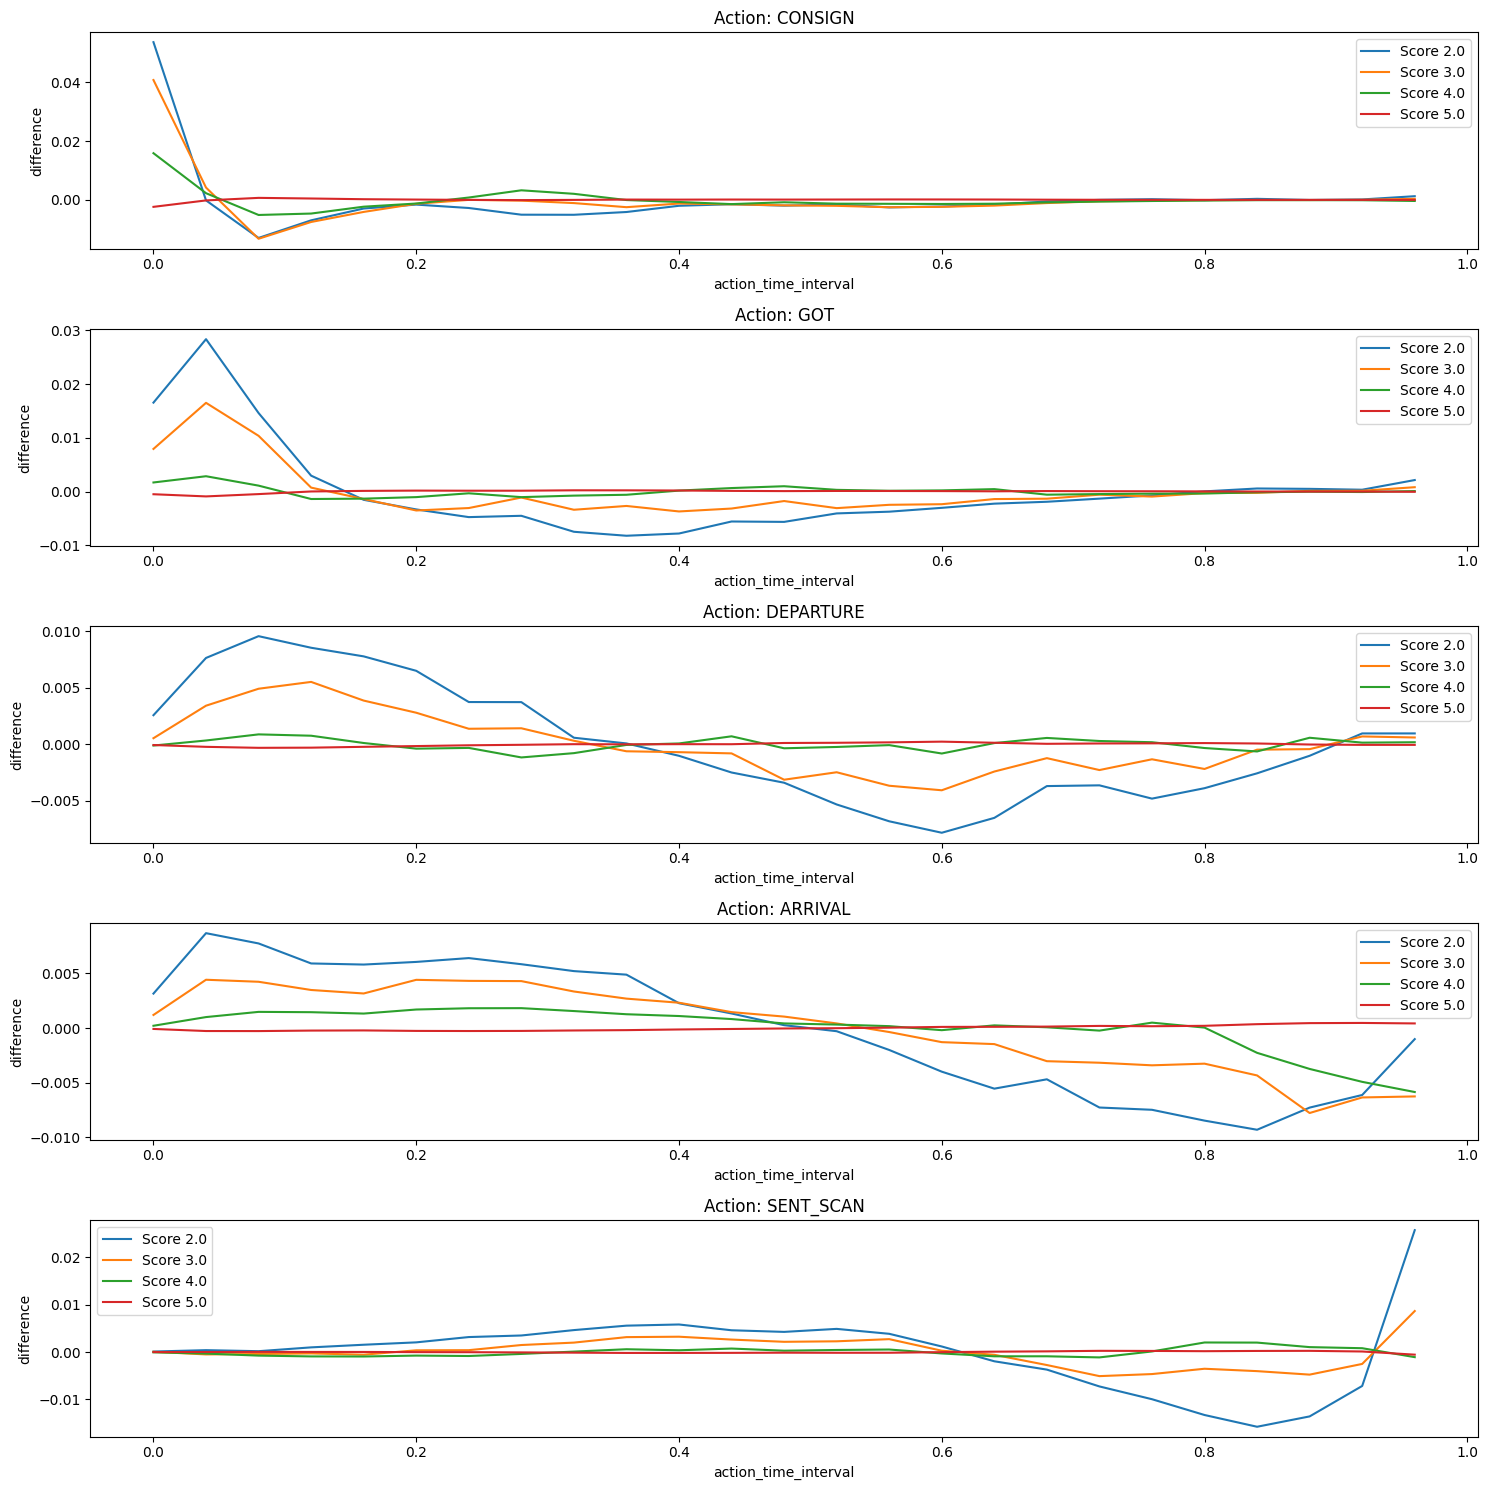

In [21]:
# Plot
plt.figure(figsize=(12, 8))
actions = ["CONSIGN", "GOT", "DEPARTURE", "ARRIVAL", "SENT_SCAN"]

# Define the number of actions and calculate the number of rows/cols for the subplot grid
num_actions = len(actions)
cols = 1
rows = num_actions // cols + (num_actions % cols > 0)  # Calculate the needed rows

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))  # Adjust figsize as necessary
axs = axs.flatten()  # Flatten the axis array for easy iteration if it's 2D

for idx, action in enumerate(actions):
    subset = distribution_difference[distribution_difference['action'] == action]
    
    for score in subset['logistics_review_score'].unique():
        score_subset = subset[subset['logistics_review_score'] == score]
        # Plot on the subplot axes
        sns.lineplot(x='action_time_interval', y='difference', data=score_subset, label=f'Score {score}', ax=axs[idx])
    
    axs[idx].set_title(f"Action: {action}")
    axs[idx].legend()

# Adjust layout
plt.tight_layout()
plt.show()
